# Comparison Cost-sensitive ML models

In [71]:
from collections import Counter
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate)
from src.utils import (print_training_results, plot_roc_cm)

In [7]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input Data

In [54]:
df = pd.read_csv("../data/data_143_features.csv")
print(df.shape)
df.head()

(50847, 144)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs,hit
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000

## 2) ML model configs

In [65]:
with open("config_files/config_cost_sensitive_clfs.yaml", "r") as file:
    config = yaml.safe_load(file)

# ML configs
SEED = config["SEED"]["seed"]
xgboost_configs = config["xgboost"]
balanced_rf_configs = config["balanced_rf"]
logistic_regression_configs = config["logistic_regression"]

### 2.1) Train/Test split

In [56]:
X = df.drop(columns=["hit"]).copy(deep=True)
print(X.shape)
X.head()

(50847, 143)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0

In [57]:
nan_features = X.isna().sum().reset_index().rename(columns={"index": "features", 0: "is_na"})
nan_features[nan_features["is_na"] == 1]

,features,is_na


In [58]:
y = df[['hit']].astype('int64').copy(deep=True)
num_classses = Counter(y.values.ravel())
print(num_classses)
y.head()

Counter({0: 49936, 1: 911})


,hit
0,0
1,0
2,0
3,0
4,0


## 3) ML training

In [68]:
# CV:
stratified_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state= SEED)

# scoring:
scoring = {"sensitivity": "recall", 
           "f1_score": "f1", 
           "precision": "precision",
           "auroc": "roc_auc",  
           "brier score": "neg_brier_score"}

### 3.1) Cost-sensitive XGBoost

In [72]:
%%time

# XGBoost training
xgboost_model = xgb.XGBClassifier(**xgboost_configs)
xgboost_cv_results = cross_validate(xgboost_model, 
                                 X, 
                                 y.values.ravel(), 
                                 cv= stratified_cv, 
                                 scoring= list(scoring.values()), 
                                 return_train_score= False, 
                                 verbose=0)

# Print results
print_training_results(scoring_dict=scoring, input_model=xgboost_model, cv_results=xgboost_cv_results)

----------
XGBClassifier mean-sensitivity: 0.7244 (+/-  0.04)
XGBClassifier mean-f1_score: 0.1264 (+/-  0.01)
XGBClassifier mean-precision: 0.0693 (+/-  0.00)
XGBClassifier mean-auroc: 0.8239 (+/-  0.02)
XGBClassifier mean-brier score: -0.1638 (+/-  0.00)
----------
CPU times: user 1min 9s, sys: 993 ms, total: 1min 10s
Wall time: 29.9 s


30it [00:28,  1.04it/s]


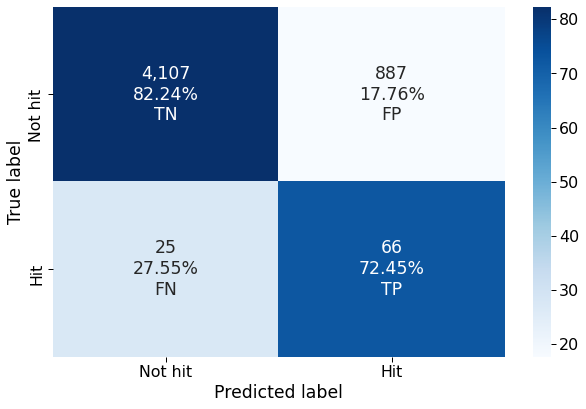

In [73]:
# Plot confussion matrix
plot_roc_cm(model= xgboost_model, cv=stratified_cv, X=X, y=y)

### 3.2) Balanced random-forest

In [75]:
%%time

# Balanced random-forest training
b_rf = BalancedRandomForestClassifier(**balanced_rf_configs)
rf_cv_results = cross_validate(b_rf, 
                               X, 
                               y.values.ravel(), 
                               cv= stratified_cv, 
                               scoring= list(scoring.values()), 
                               return_train_score= False, 
                               verbose=0)

# Print results
print_training_results(scoring_dict=scoring, input_model=b_rf, cv_results=rf_cv_results)

----------
BalancedRandomForestClassifier mean-sensitivity: 0.7603 (+/-  0.04)
BalancedRandomForestClassifier mean-f1_score: 0.1240 (+/-  0.01)
BalancedRandomForestClassifier mean-precision: 0.0675 (+/-  0.00)
BalancedRandomForestClassifier mean-auroc: 0.8438 (+/-  0.02)
BalancedRandomForestClassifier mean-brier score: -0.1460 (+/-  0.00)
----------
CPU times: user 38.3 s, sys: 1.36 s, total: 39.7 s
Wall time: 39.6 s


30it [00:37,  1.27s/it]


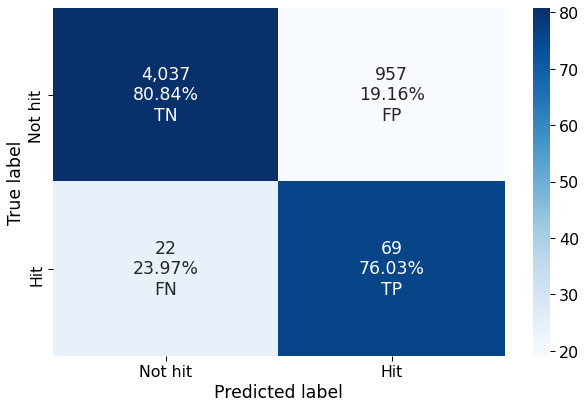

In [76]:
# Plot confussion matrix
plot_roc_cm(model= b_rf, cv=stratified_cv, X=X, y=y)

### 3.3) Logistic regression

In [78]:
%%time

# Logistic regression training
logistic_model = LogisticRegression(**logistic_regression_configs)
logistic_regression_cv_results = cross_validate(logistic_model, 
                                                X, 
                                                y.values.ravel(), 
                                                cv= stratified_cv, 
                                                scoring= list(scoring.values()), 
                                                return_train_score= False, 
                                                verbose=0)

# Print results
print_training_results(scoring_dict=scoring, input_model=logistic_model, cv_results=logistic_regression_cv_results)

----------
LogisticRegression mean-sensitivity: 0.6165 (+/-  0.04)
LogisticRegression mean-f1_score: 0.1303 (+/-  0.01)
LogisticRegression mean-precision: 0.0729 (+/-  0.00)
LogisticRegression mean-auroc: 0.7927 (+/-  0.02)
LogisticRegression mean-brier score: -0.1442 (+/-  0.00)
----------
CPU times: user 37 s, sys: 28.5 s, total: 1min 5s
Wall time: 31.4 s


30it [00:32,  1.07s/it]


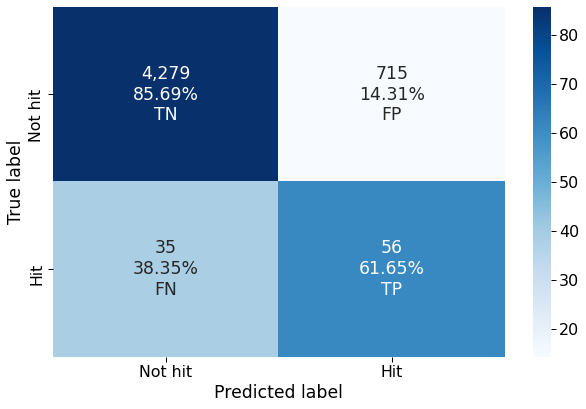

In [80]:
# Plot confussion matrix
plot_roc_cm(model= logistic_model, cv=stratified_cv, X=X, y=y)